In [43]:
import pandas as pd
%matplotlib inline

In [2]:
trial1_data = pd.read_csv('trail1_data.csv', low_memory=False)

In [3]:
trial1_data.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,target,day,month,year
0,489652,6578,10-Sep-05,4,0,0,0,2,1.0,10,9,2005
1,507246,6578,18-Aug-05,45,5,0,0,7,0.0,18,8,2005
2,523729,6534,29-Apr-06,0,0,0,0,0,1.0,29,4,2006
3,524931,6535,07-Feb-04,0,0,0,0,0,0.0,7,2,2004
4,521364,6529,28-Feb-06,15,1,0,0,7,1.0,28,2,2006


In [4]:
healthcamp = pd.read_csv('data/Train/Health_Camp_Detail.csv', low_memory=False)

In [5]:
healthcamp.head()

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2
2,6544,03-Nov-03,15-Nov-03,First,F,1
3,6585,22-Nov-03,05-Dec-03,First,E,2
4,6561,30-Nov-03,18-Dec-03,First,E,1


In [14]:
healthcamp['days_active'] = (pd.to_datetime(healthcamp.Camp_End_Date) - pd.to_datetime(healthcamp.Camp_Start_Date)).apply(lambda x: x.days)

In [23]:
healtcamp_cols = ['Health_Camp_ID', 'Category1', 'Category2', 'Category3', 'days_active']
trial2data = pd.merge(trial1_data, healthcamp[healtcamp_cols], on='Health_Camp_ID')

In [25]:
trial2data.columns

Index(['Patient_ID', 'Health_Camp_ID', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5',
       'target', 'day', 'month', 'year', 'Category1', 'Category2', 'Category3',
       'days_active'],
      dtype='object')

In [29]:
target_data = pd.get_dummies(trial2data, columns=['Category1', 'Category2', 'Category3'])

In [30]:
trainset = target_data[0:75278]
testset = target_data[75278:]

In [31]:
import xgboost as xgb

In [32]:
partial_trainset = trainset[trainset['year'].isin([2004, 20005])]
validation_set = trainset[trainset['year'] > 2005]

train_cols = [col for col in trainset.columns if col != 'target']
X_train = partial_trainset[train_cols]
Y_train = partial_trainset['target']

X_val = validation_set[train_cols]
Y_val = validation_set['target']

X_test = testset[train_cols]
Y_test = testset['target']

In [33]:
dtrain = xgb.DMatrix(X_train.as_matrix(), label=Y_train.as_matrix(), feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix(), feature_names=X_test.columns)
dval = xgb.DMatrix(X_val.as_matrix(), label=Y_val.as_matrix(), feature_names=X_val.columns)

In [34]:
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [54]:
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.003
params["min_child_weight"] = 1
params["subsample"] = 0.8
# params["colsample_bytree"] = 0.8
params["scale_pos_weight"] = 1.0
# params["silent"] = 1
params["max_depth"] = 5
params["nthread"] = 4
params["eval_metric"] = "auc"

In [55]:
num_rounds = 500
model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	train-auc:0.715394	eval-auc:0.764127
[1]	train-auc:0.715549	eval-auc:0.764127
[2]	train-auc:0.716590	eval-auc:0.764135
[3]	train-auc:0.717117	eval-auc:0.764135
[4]	train-auc:0.715975	eval-auc:0.764058
[5]	train-auc:0.717130	eval-auc:0.764091
[6]	train-auc:0.718650	eval-auc:0.764411
[7]	train-auc:0.717730	eval-auc:0.764389
[8]	train-auc:0.717689	eval-auc:0.764389
[9]	train-auc:0.741513	eval-auc:0.764353
[10]	train-auc:0.741671	eval-auc:0.764353
[11]	train-auc:0.742014	eval-auc:0.764353
[12]	train-auc:0.742094	eval-auc:0.764281
[13]	train-auc:0.742105	eval-auc:0.764270
[14]	train-auc:0.742026	eval-auc:0.764270
[15]	train-auc:0.741977	eval-auc:0.764270
[16]	train-auc:0.742015	eval-auc:0.764270
[17]	train-auc:0.742484	eval-auc:0.764270
[18]	train-auc:0.742587	eval-auc:0.764270
[19]	train-auc:0.742592	eval-auc:0.764298
[20]	train-auc:0.742924	eval-auc:0.764347
[21]	train-auc:0.742756	eval-auc:0.764347
[22]	train-auc:0.743384	eval-auc:0.765418
[23]	train-auc:0.743164	eval-auc:0.765418
[2

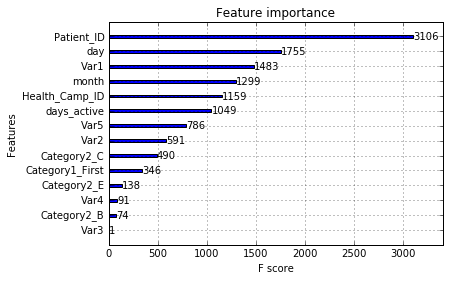

In [56]:
xgb.plot_importance(model)

In [51]:
predictions = model.predict(dtest)
submission = X_test[['Patient_ID', 'Health_Camp_ID']]
submission['Outcome'] = predictions

/home/jayant/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [52]:
submission.head()

,Patient_ID,Health_Camp_ID,Outcome
75278,505701,6548,0.489592
75279,494067,6548,0.538113
75280,499854,6548,0.542177
75281,509140,6548,0.533054
75282,486481,6548,0.542177


In [53]:
submission.to_csv('trial_2_submission.csv', index=False)

In [58]:
target_data.to_csv('trial2_data.csv', index=False)

In [59]:
len(submission)

35249